In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [108]:
df_train = pd.read_parquet('data/input_dataset-2.parquet')
df_test = pd.read_parquet('data/prediction_input.parquet')

## Remove irrellevant columns

Text(0, 0.5, 'Percentage [%]')

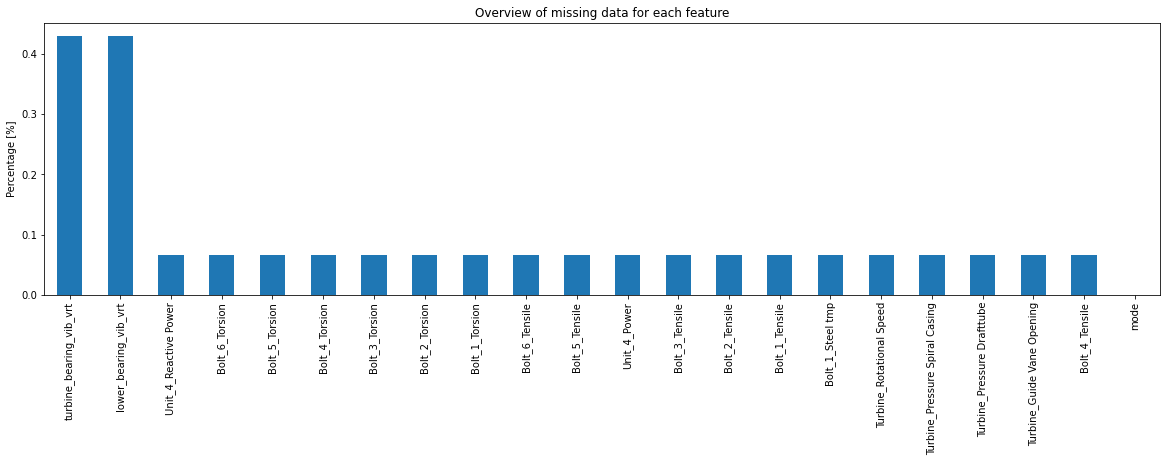

In [109]:
(df_train.isna().sum()/len(df_train)).sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title("Overview of missing data for each feature")
plt.ylabel("Percentage [%]")

In [110]:
cols_keep = list(df_test.columns) + [f'Bolt_{i}_Tensile' for i in range(1,7)]
cols_num = list(df_test.drop(columns='mode').columns)
cols_cat = ['mode']

In [111]:
# Extract relevant features
df_train = df_train[cols_keep]
df_train.head(3).T

timepoints,1970-12-19 09:51:44,1970-12-19 09:51:45,1970-12-19 09:51:46
Unit_4_Power,262.204308,262.104319,262.00433
Unit_4_Reactive Power,2.899036,3.34463,3.790223
Turbine_Guide Vane Opening,82.279976,82.277248,82.27452
Turbine_Pressure Drafttube,173.955216,173.989815,174.024413
Turbine_Pressure Spiral Casing,5310.799181,5311.219755,5311.640329
Turbine_Rotational Speed,107.964278,107.964273,107.964269
mode,operation,operation,operation
Bolt_1_Tensile,1598.48139,1598.477449,1598.479316
Bolt_2_Tensile,1480.989917,1480.989528,1481.003188
Bolt_3_Tensile,1684.247079,1684.261611,1684.270504


## Remove all rows with missing values

In [112]:
print('TRAINING SET')
print(f"Length of full dataset: {len(df_train):,}")
print(f"Remaining rows after dropping all NaNs: {len(df_train[~df_train.isna().any(axis=1)]):,}")
print(f"Loss: {100*(df_train.isna().any(axis=1).sum() / len(df_train)):.2f} %")
print()

print('TEST SET')
print(f"Length of full dataset: {len(df_test):,}")
print(f"Remaining rows after dropping all NaNs: {len(df_test[~df_test.isna().any(axis=1)]):,}")
print(f"Loss: {100*(df_test.isna().any(axis=1).sum() / len(df_test)):.2f} %")

TRAINING SET
Length of full dataset: 1,874,087
Remaining rows after dropping all NaNs: 1,750,000
Loss: 6.62 %

TEST SET
Length of full dataset: 226,364
Remaining rows after dropping all NaNs: 226,364
Loss: 0.00 %


In [113]:
# Remove rows that contain any missing values
df_train = df_train.dropna()
assert df_train.isna().any().sum() == 0

## Create sliding window

In [114]:
# Create timeslots that contain "safe" data without jumps

time_jumps_sec = (df_train.index[1:] - df_train.index[:-1]).seconds

timeslots_start = [df_train.index[0]] + list(df_train.index[1:][time_jumps_sec>1])
timeslots_end = list(df_train.index[:-1][time_jumps_sec>1]) + [df_train.index[-1]]

timeslots = [(ts_start, ts_end) for ts_start, ts_end in zip(timeslots_start, timeslots_end)]
timeslots

[(Timestamp('1970-12-19 09:51:44'), Timestamp('1970-12-24 00:01:29')),
 (Timestamp('1970-12-24 03:55:18'), Timestamp('1970-12-24 03:58:53')),
 (Timestamp('1970-12-24 04:00:46'), Timestamp('1970-12-27 22:00:52')),
 (Timestamp('1970-12-28 06:25:21'), Timestamp('1970-12-28 06:28:33')),
 (Timestamp('1970-12-28 06:30:49'), Timestamp('1970-12-28 08:00:50')),
 (Timestamp('1970-12-28 08:16:23'), Timestamp('1970-12-28 08:19:31')),
 (Timestamp('1970-12-28 08:20:27'), Timestamp('1970-12-29 00:01:08')),
 (Timestamp('1970-12-29 04:41:21'), Timestamp('1970-12-29 04:44:38')),
 (Timestamp('1970-12-29 04:46:47'), Timestamp('1970-12-29 18:49:21')),
 (Timestamp('1970-12-29 18:50:26'), Timestamp('1970-12-29 19:01:28')),
 (Timestamp('1970-12-29 19:55:16'), Timestamp('1970-12-29 19:58:50')),
 (Timestamp('1970-12-29 20:00:47'), Timestamp('1970-12-29 20:26:25')),
 (Timestamp('1970-12-31 11:58:50'), Timestamp('1970-12-31 12:02:32')),
 (Timestamp('1970-12-31 12:04:56'), Timestamp('1970-12-31 17:46:11')),
 (Time

In [115]:
# Example: Notice the jump in time
# This timeslot contains the timeslot end + the next two
# timesteps (which belongs would belong to the next timeslot)
df_train.loc[timeslots[0][1]:].head(3)

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,,,,,,,,
1970-12-24 00:01:29,101.249005,-18.795975,40.571212,223.112684,5497.962538,105.981726,operation,1598.500102,1478.786592,1683.053715,1596.922610,1633.424227,1670.371219
1970-12-24 03:55:18,0.000000,0.000000,1.235328,230.235378,4635.442549,0.955234,start,1523.662082,1425.632422,1665.702272,1556.012626,1596.237456,1610.361362
1970-12-24 03:55:19,0.000000,0.000000,1.237633,230.158516,4671.412655,0.957016,start,1524.566894,1426.169392,1665.869544,1556.394219,1596.612592,1610.871875


In [132]:
WINDOWS_SIZE = dt.timedelta(seconds=30)
new_dfs = []

# for ts_start, ts_end in timeslots:
    # TODO: Create look-back features with WINDOWS_SIZE seconds look-back


In [135]:
ts_start, ts_end = timeslots[0]

for t_lookback in range(WINDOWS_SIZE.seconds):
    df_train.loc[ts_start+WINDOWS_SIZE:ts_end]

Unit_4_Power                       262.204308
Unit_4_Reactive Power                2.899036
Turbine_Guide Vane Opening          82.279976
Turbine_Pressure Drafttube         173.955216
Turbine_Pressure Spiral Casing    5310.799181
Turbine_Rotational Speed           107.964278
mode                                operation
Bolt_1_Tensile                     1598.48139
Bolt_2_Tensile                    1480.989917
Bolt_3_Tensile                    1684.247079
Bolt_4_Tensile                    1601.359944
Bolt_5_Tensile                      1635.5857
Bolt_6_Tensile                    1674.848803
Name: 1970-12-19 09:51:44, dtype: object

In [131]:
pd.concat([df_train.iloc[:5, 0].shift(i) for i in range(3)], axis=1)

,Unit_4_Power,Unit_4_Power,Unit_4_Power
timepoints,,,
1970-12-19 09:51:44,262.204308,NaN,NaN
1970-12-19 09:51:45,262.104319,262.204308,NaN
1970-12-19 09:51:46,262.004330,262.104319,262.204308
1970-12-19 09:51:47,261.904340,262.004330,262.104319
1970-12-19 09:51:48,261.804351,261.904340,262.004330


In [117]:
def get_sequences(ts, window):
    shape = (len(ts) - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

def sequence_columns(df: pd.DataFrame, window: int):
    sequences = []
    for column in df.columns:
        sequences.append(get_sequences(df[column].to_numpy(), window))

    col_names = [f"{column}_t{i}" for column in df.columns for i in range(window)]
    return pd.DataFrame(np.hstack(sequences), columns=col_names, index=df.index[:(len(df)-window+1)])

In [121]:
df_train.iloc[:5,0]

timepoints
1970-12-19 09:51:44    262.204308
1970-12-19 09:51:45    262.104319
1970-12-19 09:51:46    262.004330
1970-12-19 09:51:47    261.904340
1970-12-19 09:51:48    261.804351
Name: Unit_4_Power, dtype: float64

In [120]:
get_sequences(df_train.iloc[:5,0].to_numpy(), 2)

array([[262.20430804, 262.10431881],
       [262.10431881, 262.00432958],
       [262.00432958, 261.90434035],
       [261.90434035, 261.80435112]])

In [90]:
df_train.iloc[:3,:2]

,Unit_4_Power,Unit_4_Reactive Power
timepoints,,
1970-12-19 09:51:44,262.204308,2.899036
1970-12-19 09:51:45,262.104319,3.344630
1970-12-19 09:51:46,262.004330,3.790223


In [92]:
sequence_columns(df_train.iloc[:30,:2], 3)

TypeError: bad operand type for unary -: 'tuple'

In [84]:
new_df.iloc[:,0]

timepoints
1970-12-19 09:51:44    262.204308
1970-12-19 09:51:45    262.104319
1970-12-19 09:51:46    262.004330
1970-12-19 09:51:47    261.904340
1970-12-19 09:51:48    261.804351
                          ...    
1970-12-24 00:01:25    113.463234
1970-12-24 00:01:26    110.314307
1970-12-24 00:01:27    107.292540
1970-12-24 00:01:28    104.270772
1970-12-24 00:01:29    101.249005
Name: Unit_4_Power, Length: 396586, dtype: float64

Text(0, 0.5, 'Seconds')

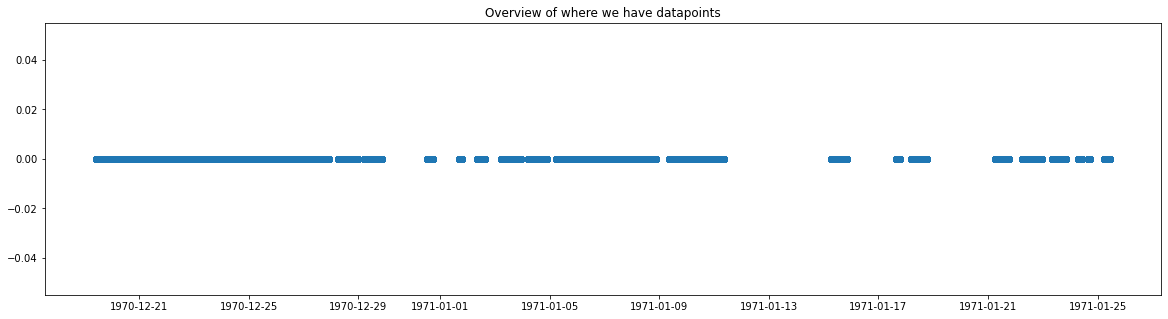

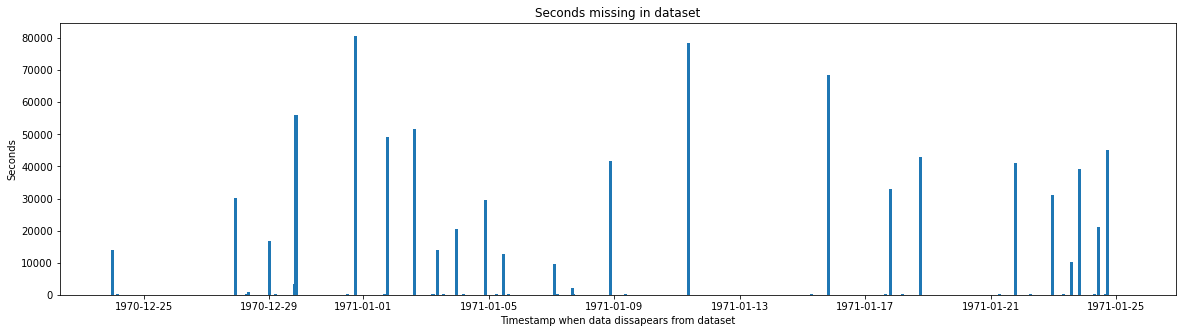

In [61]:
# Plot overview of where we have datapoints
plt.figure(figsize=(20,5))
plt.scatter(df_train.index, [0]*len(df_train))
plt.title('Overview of where we have datapoints')

# Plot seconds missing in dataset
plt.figure(figsize=(20,5))
plt.bar(
    x = time_jump_dt,
    height = time_jumps_sec[time_jumps_sec>1],
    width=0.1
)
plt.title("Seconds missing in dataset")
plt.xlabel("Timestamp when data dissapears from dataset")
plt.ylabel("Seconds")

In [62]:
timeslots = [df_train.index[0]] + list(time_jump_dt) + [df_train.index[-1]]
timeslots

[Timestamp('1970-12-19 09:51:44'),
 Timestamp('1970-12-24 00:01:29'),
 Timestamp('1970-12-24 03:58:53'),
 Timestamp('1970-12-27 22:00:52'),
 Timestamp('1970-12-28 06:28:33'),
 Timestamp('1970-12-28 08:00:50'),
 Timestamp('1970-12-28 08:19:31'),
 Timestamp('1970-12-29 00:01:08'),
 Timestamp('1970-12-29 04:44:38'),
 Timestamp('1970-12-29 18:49:21'),
 Timestamp('1970-12-29 19:01:28'),
 Timestamp('1970-12-29 19:58:50'),
 Timestamp('1970-12-29 20:26:25'),
 Timestamp('1970-12-31 12:02:32'),
 Timestamp('1970-12-31 17:46:11'),
 Timestamp('1971-01-01 16:13:41'),
 Timestamp('1971-01-01 18:46:24'),
 Timestamp('1971-01-02 08:29:21'),
 Timestamp('1971-01-02 14:51:12'),
 Timestamp('1971-01-03 05:14:01'),
 Timestamp('1971-01-03 09:01:24'),
 Timestamp('1971-01-03 12:58:51'),
 Timestamp('1971-01-03 23:01:07'),
 Timestamp('1971-01-04 04:43:58'),
 Timestamp('1971-01-04 21:31:06'),
 Timestamp('1971-01-05 05:48:55'),
 Timestamp('1971-01-05 11:15:25'),
 Timestamp('1971-01-05 14:48:36'),
 Timestamp('1971-01-

In [6]:
# Show the time jumps (look at the index timestamp)
for timestamp, delta_time in zip(time_jump_dt, time_jumps_sec[time_jumps_sec>1]):
    print(df_train.loc[timestamp:,'Unit_4_Power'].head(2))
    print(f"Time-jump: {delta_time} sec")
    print()

timepoints
1970-12-28 06:28:33      0.00000
1970-12-28 06:30:49    102.95981
Name: Unit_4_Power, dtype: float64
Time-jump: 16 sec

timepoints
1970-12-29 00:01:08    102.03335
1970-12-29 04:41:21      0.00000
Name: Unit_4_Power, dtype: float64
Time-jump: 13 sec

timepoints
1970-12-29 04:44:38      0.000000
1970-12-29 04:46:47    102.248808
Name: Unit_4_Power, dtype: float64
Time-jump: 9 sec

timepoints
1970-12-29 20:27:38    NaN
1970-12-31 11:58:50    0.0
Name: Unit_4_Power, dtype: float64
Time-jump: 12 sec

timepoints
1970-12-31 17:47:02   NaN
1971-01-01 16:10:16   NaN
Name: Unit_4_Power, dtype: float64
Time-jump: 14 sec

timepoints
1971-01-01 18:48:02    NaN
1971-01-02 08:25:16    0.0
Name: Unit_4_Power, dtype: float64
Time-jump: 14 sec

timepoints
1971-01-02 08:29:21    0.0
1971-01-02 08:29:23    NaN
Name: Unit_4_Power, dtype: float64
Time-jump: 2 sec

timepoints
1971-01-03 09:03:12    NaN
1971-01-03 12:55:26    0.0
Name: Unit_4_Power, dtype: float64
Time-jump: 14 sec

timepoints
197

In [7]:
df_train.loc[df_train.index[:-1][time_jumps>1][1]:].head(3)

NameError: name 'time_jumps' is not defined

In [37]:
start_ts = df_train[df_train['mode'] == 'start'].index
secs_since_last_start = (start_ts[1:] - start_ts[:-1]).seconds

last_start_before_counting = start_ts[:-1][secs_since_last_start > 1]

In [55]:
last_start_before_counting = list(last_start_before_counting)
last_start_before_counting.append(df_train.index[-1])
last_start_before_counting

[Timestamp('1970-12-24 03:58:53'),
 Timestamp('1970-12-28 06:28:33'),
 Timestamp('1970-12-28 08:19:31'),
 Timestamp('1970-12-29 04:44:38'),
 Timestamp('1970-12-29 19:58:50'),
 Timestamp('1970-12-31 12:02:32'),
 Timestamp('1971-01-01 16:13:41'),
 Timestamp('1971-01-02 08:29:21'),
 Timestamp('1971-01-03 05:14:01'),
 Timestamp('1971-01-03 12:58:51'),
 Timestamp('1971-01-04 04:43:58'),
 Timestamp('1971-01-05 05:48:55'),
 Timestamp('1971-01-05 14:48:36'),
 Timestamp('1971-01-07 04:43:47'),
 Timestamp('1971-01-09 08:49:04'),
 Timestamp('1971-01-14 06:58:42'),
 Timestamp('1971-01-15 06:28:45'),
 Timestamp('1971-01-17 15:03:34'),
 Timestamp('1971-01-18 04:13:38'),
 Timestamp('1971-01-21 06:14:09'),
 Timestamp('1971-01-22 06:13:30'),
 Timestamp('1971-01-23 07:43:43'),
 Timestamp('1971-01-23 16:32:13'),
 Timestamp('1971-01-24 06:58:33'),
 Timestamp('1971-01-24 15:58:54'),
 Timestamp('1971-01-25 11:06:48')]

In [56]:
df_train['sec_since_last_start'] = 0

for t1, t2 in zip(last_start_before_counting[:-1], last_start_before_counting[1:]):
    df_train.loc[t1:t2, 'sec_since_last_start'] = range(len(df_train[t1:t2]))

df_train.loc[df_train['mode'] == 'start', 'sec_since_last_start'] = 0

In [57]:
df_train.loc[t1:t2, ['mode', 'sec_since_last_start']]

,mode,sec_since_last_start
timepoints,,
1971-01-24 15:58:54,start,0
1971-01-24 15:58:55,operation,1
1971-01-24 15:58:56,operation,2
1971-01-24 15:58:57,operation,3
1971-01-24 15:58:58,operation,4
...,...,...
1971-01-25 11:06:44,operation,23840
1971-01-25 11:06:45,operation,23841
1971-01-25 11:06:46,operation,23842
